
### Overview:

This notebook aims to help users combine their investment portfolio with a risk-free asset to determine the optimal allocation. It provides both a demo mode with preset values and an interactive mode where users can input their own parameters. The process involves fetching stock price data, calculating portfolio metrics, optimizing the asset weights to maximize the Sharpe ratio, and allowing the user to specify targets for either volatility or return. The final output is a breakdown of the optimal portfolio composition.


## Part I: Initial Setup

System initialisation

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings

Determine if we will be working in demo or interactive mode.

In [2]:
is_demo= input("Is this a demo? If yes it won't ask you for inputs everything will be preset, otherwise it will be interactive. (y/n)")
while is_demo not in ["y", "n"]:
    is_demo = input("Please enter y or n: ")

is_demo = True if is_demo == "y" else False 
is_demo: print("Demo mode is on") if is_demo else print("Interactive mode is off")

Demo mode is on


Input of inital data: prompt user for initialisation data like risk-free rate, budget etc.


In [3]:
if is_demo:
    risk_free_rate = 0.02
    print(f"Risk free rate: {risk_free_rate*100}%")
    budget = 100000
    print(f"Budget: {round(budget,2)} USD")
    end_date = dt.datetime.now()
    start_date = end_date - dt.timedelta(days=365)
    print('Demo dates chosen')
else:
    risk_free_rate = float(input("Enter the risk free rate in %: "))/100
    print(f"Risk free rate: {risk_free_rate*100}%")
    budget = float(input("Enter the budget in USD: "))
    print(f"Budget: {round(budget,2)} USD")
    end_date = dt.datetime.now()
    days_back = int(input("Enter the number of days back to start the analysis: "))
    start_date = end_date - dt.timedelta(days=days_back)
    print(f'Custom dates chosen. Go back {days_back} days from today')


if is_demo:
    prompt = "2"
else:
    prompt = input("Do you want to use the full S&P500 (1), default partial list (2) or a custom list (3)? \n NOTE: The full will take a while to run.\n")
    while prompt not in ["1", "2", "3"]:
        prompt = input("Please enter 1, 2 or 3: ")


if prompt == "2":
    ticker_list = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'TSLA', 'BRK-A', 'V', 'JPM', 'JNJ', 
               'WMT', 'PG', 'NVDA', 'MA', 'HD', 'UNH', 'DIS', 'BAC', 'PYPL', 'VZ', 
               'CMCSA', 'KO', 'NFLX', 'XOM', 'CVX', 'INTC', 'CSCO', 'PFE', 'ADBE', 'NKE', 
               'ABT', 'C', 'TMO', 'MRK', 'CRM', 'MA', 'TSM', 'MMM', 'BA', 'PEP', 'MCD', 
               'HON', 'ACN', 'WFC', 'BA', 'COST', 'BMY', 'SBUX', 'IBM', 'ORCL']
    print('Demo list of stocks chosen')
elif prompt == "1":
    ticker_list=list(pd.read_csv('SP500_tickers.csv',header=None)[0])
    print('Full SP500 list of stocks chosen')
else:
    tickers = input("Please enter a list of tickers separated by commas: ").split(",")
    print('Custom list of stocks chosen')


Risk free rate: 2.0%
Budget: 100000 USD
Demo dates chosen
Full SP500 list of stocks chosen


## Part II: Function Setup 

Information fetching function 

In [4]:
def get_data(tickers, start_date, end_date):
    '''
    Get closing price for given tickers from Yahoo Finance. 
    Ouput is a table with mean and covariance matrix
    '''
    print("Getting data from Yahoo Finance...")
    yfin.pdr_override() #solves the problem with pdr.get_data_yahoo
    prices= pdr.get_data_yahoo(tickers, start=start_date, end=end_date)["Close"]
    prices=prices.dropna(axis=1) #drop columns with NaN values
    data= prices.pct_change() #this gets returns on closing price
    mean_returns=data.mean()
    cov_matrix=data.cov()
    return mean_returns, cov_matrix, prices.tail(1)

Define functions to provide metrics that will be optimised

In [5]:
def portofolio_metrics(weights, mean_returns, cov_matrix):
    '''
    calculate the returns and volatility of a portfolio given weights
    '''
    returns=np.sum(mean_returns*weights)*252
    std=np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*np.sqrt(252)
    return returns, std

def negative_sr(weights, mean_returns, cov_matrix, risk_free_rate=0):
    '''
    Function to be minimised for the maximisation of the sharpe ratio
    '''
    p_ret, p_std = portofolio_metrics(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_std

def volatility(weights, mean_returns, cov_matrix):
    '''
    Function to be minimised for the minimisation of the volatility
    '''
    return portofolio_metrics(weights, mean_returns, cov_matrix)[1]

Define optimisation functions 

In [6]:
# Use Scipy to optimize the weights thorough fpr the maximisation of the sharpe ratio
def maximise_sr(mean_returns, cov_matrix, risk_free_rate=risk_free_rate, constraint_set=(0,1)):
    '''
    Maximise the sharpe ratio by altering weights
    '''
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraint_set
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(negative_sr, num_assets*[1./num_assets], args=args, method='SLSQP',bounds=bounds, constraints=constraints)
    #print("Maximium Sharpe Ratio: ", result['fun'], "\nWeights: ", result['x'])
    return result['fun'], result['x']

#Given a target return, find the weights that give the lowest volatility
def target_portfolio(mean_returns, cov_matrix, target_return, constraint_set=(0,1)):
    '''
    Given a target return, find the weights that give the lowest volatility
    '''
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: portofolio_metrics(x, mean_returns, cov_matrix)[0] - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraint_set
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(volatility, num_assets*[1./num_assets], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    #print("Target Portfolio Volatility: ", result['fun'], "\nWeights: ", result['x'])
    return result['fun'], result['x']

#Create a function to give a list for the efficient frontier
def efficient_frontier(mean_returns, cov_matrix, max_sr_return, constraint_set=(0,1)):
        '''
        Create a list of weights for the efficient frontier
        '''
        frontier_y = np.linspace(0, max_sr_return*2, 40)
        frontier_x = []
        for possible_return in frontier_y:
            frontier_x.append(target_portfolio(mean_returns, cov_matrix, possible_return, constraint_set=(0,1))[0])
        return frontier_x, frontier_y



Define a function that will combine it all and give nice output 

In [7]:
# Output with a table and a graph
def table_output(mean_returns, cov_matrix, risk_free_rate=0, constraint_set=(0,1), target_return=-0.01):
    '''
    Output the results in a table
    '''
    warnings.filterwarnings("ignore")
    print('Processing data...')
    #for the maximisation of the sharpe ratio
    max_sr, max_weights = maximise_sr(mean_returns, cov_matrix, risk_free_rate, constraint_set)
    max_sr_returns, max_sr_volatility = portofolio_metrics(max_weights, mean_returns, cov_matrix)
    df_sr=pd.DataFrame(max_weights, index=mean_returns.index, columns=['Weights'])
    df_sr.Weights=[round(100*weight,2) for weight in df_sr.Weights]
    df_sr.drop(df_sr[df_sr['Weights'] < 0.000001].index, inplace = True)

    #we will later need the price of the max_sr portfolio
    max_sr_price=prices.tail(1).dot(max_weights)
    
    #to create a list with all points on efficient frontier
    ef_x, ef_y = efficient_frontier(mean_returns, cov_matrix, max_sr_returns)
    
    #print the results for the maximum Sharpe Ration and the Minimum Volatility Portfolios
    print("\n\nMaximimum Sharpe Ratio Portfolio")
    print("Expected annualised return: ", round(100*max_sr_returns,2), "%")
    print("Expected annualised volatility: ", round(100*max_sr_volatility,2), "%")
    print("Price of the portfolio: ", round(max_sr_price[0],2), "USD")
    print(df_sr)
    
    
    #Add the CML line
    x_vol= np.linspace(min(ef_x)*.6, .4, 10)
    slope= (max_sr_returns-risk_free_rate)/max_sr_volatility
    y_ret= risk_free_rate + x_vol*slope

    #plot the results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ef_x, ef_y, linestyle='--', color='black')
    ax.plot(x_vol, y_ret, linestyle='-', color='black')
    ax.plot(max_sr_volatility, max_sr_returns, marker='o', color='red')
    plt.xlim(min(ef_x)*.6, .40)
    plt.title('Efficient Frontier with CML')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(['Efficient Frontier', 'Capital Market Line', 'Maximum Sharpe Ratio'], loc='lower right')
    plt.grid(True)
    plt.show()

    #give an overview of possible portfolios
    print("\n\nExamples of possible combinations:")
    x_vol= np.linspace(0,40,17)
    y_ret= risk_free_rate + x_vol*slope
    df_example=pd.DataFrame({'Annualised Volatility (%)': x_vol, 'Annualised Returns (%)': np.round(y_ret,2)})
    print(df_example)
    

    return max_sr_returns, slope, max_sr_price, df_sr

## Part III: Output

Fetch Data

In [8]:
mean_returns, cov_matrix, prices = get_data(ticker_list, start_date, end_date)


Getting data from Yahoo Finance...
[*********************100%***********************]  485 of 485 completed

4 Failed downloads:
- FISV: No data found, symbol may be delisted
- PKI: No data found, symbol may be delisted
- SIVB: No data found, symbol may be delisted
- FRC: No data found, symbol may be delisted


Process data and output

Processing data...




Maximimum Sharpe Ratio Portfolio
Expected annualised return:  67.9 %
Expected annualised volatility:  21.25 %
Price of the portfolio:  303.05 USD
      Weights
CBOE     1.56
GE      28.32
LLY     35.31
MPC      0.03
NVDA     7.39
PHM      9.11
RCL     10.83
REGN     2.89
SLB      4.56


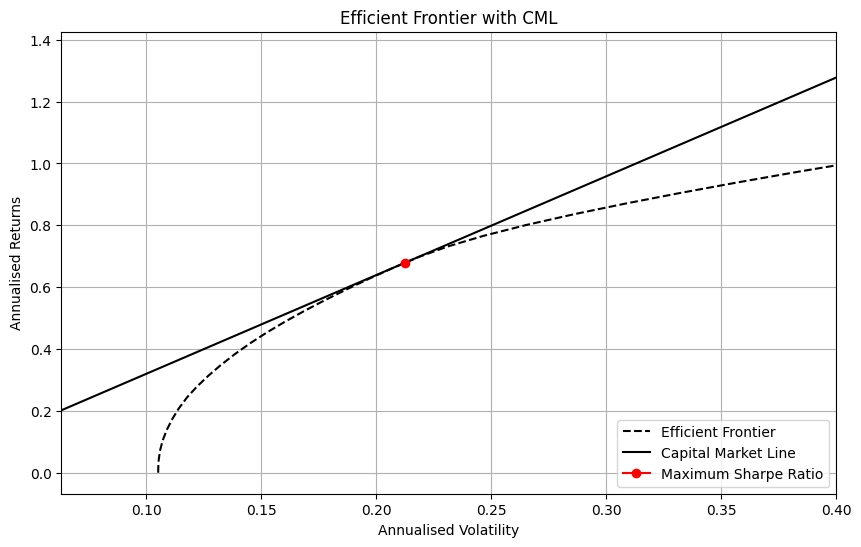



Examples of possible combinations:
    Annualised Volatility (%)  Annualised Returns (%)
0                         0.0                    0.00
1                         2.5                    7.99
2                         5.0                   15.97
3                         7.5                   23.96
4                        10.0                   31.94
5                        12.5                   39.93
6                        15.0                   47.92
7                        17.5                   55.90
8                        20.0                   63.89
9                        22.5                   71.87
10                       25.0                   79.86
11                       27.5                   87.85
12                       30.0                   95.83
13                       32.5                  103.82
14                       35.0                  111.80
15                       37.5                  119.79
16                       40.0                

In [9]:
max_sr_return, slope, max_sr_price, df_sr = table_output(mean_returns, cov_matrix)

## Part IV: Portfolio Composition with Risk-Free Asset

Now, figure out what combination of the portfolio and the risk-free it will be.

In [10]:
if is_demo:    
    #target_return = float(input("Please enter the target return in %: "))/100
    target_return = 0.10
    print(f"Target return: {round(100*target_return,2)} % \n")
    target_volatility = (target_return - risk_free_rate)/slope
    print(f"Corresponding volatility: {round(100*target_volatility,2)} % \n")
else:
    # There are two ways to approach this. Either we can ask for target volatility or we can ask for target return.
    ans= input("Do you want to enter target volatility (1) or target return (2)? ")
    while ans!= "1" and ans!= "2": ans= input("Please enter 1 or 2. Do you want to enter target volatility (1) or target return (2)? ")

    if ans== "1":
        target_volatility = float(input("Please enter the target volatility in %: "))/100
        print(f"Target volatility: {round(100*target_volatility,2)} % \n")
        target_return = risk_free_rate + target_volatility*slope
        print(f"Corresponding return: {round(100*target_return,2)} % \n")
    else:
        target_return = float(input("Please enter the target return in %: "))/100
        print(f"Target return: {round(100*target_return,2)} % \n")
        target_volatility = (target_return - risk_free_rate)/slope
        print(f"Corresponding volatility: {round(100*target_volatility,2)} % \n")

part_rf= target_return/(max_sr_return-risk_free_rate)
part_max_sr= 1-part_rf
print(f"The weights for the maximum Sharpe ratio portfolio: {round(part_max_sr,2)}\nand the weights for the risk free asset: {round(1-round(part_max_sr,2),2)}\n")

print('Budget: ', round(budget,2),"USD\n")
print(f'Allocation: \n Risk free asset:  {round((1-part_max_sr)*budget,2)} USD \n Max SR portfolio: {round(part_max_sr*budget,2)} USD ')

df_prices_l=pd.DataFrame(np.round(prices[df_sr.index.tolist()].values.T,2),index=prices[df_sr.index.tolist()].T.index,columns=['Prices (USD)'])
df_total=pd.DataFrame(np.round(budget*df_sr['Weights']/100,2))
df_num_stocks=pd.DataFrame(np.round(df_total.values/df_prices_l.values,0),index=df_total.index)
df_target= pd.concat([df_sr,df_prices_l,df_total,df_num_stocks],axis=1)
df_target.index.name='Stocks'
df_target.columns=['Weights (%)','Prices (USD)','Total invested (USD)','Number of Stocks']

print("\nMax SR portfolio breakdown:")
df_target

Target return: 10.0 % 

Corresponding volatility: 2.5 % 

The weights for the maximum Sharpe ratio portfolio: 0.85
and the weights for the risk free asset: 0.15

Budget:  100000 USD

Allocation: 
 Risk free asset:  15175.5 USD 
 Max SR portfolio: 84824.5 USD 

Max SR portfolio breakdown:


,Weights (%),Prices (USD),Total invested (USD),Number of Stocks
Stocks,,,,
CBOE,1.56,150.12,1560.0,10.0
GE,28.32,111.79,28320.0,253.0
LLY,35.31,546.43,35310.0,65.0
MPC,0.03,144.62,30.0,0.0
NVDA,7.39,432.99,7390.0,17.0
PHM,9.11,79.30,9110.0,115.0
RCL,10.83,99.20,10830.0,109.0
REGN,2.89,812.40,2890.0,4.0
SLB,4.56,58.03,4560.0,79.0
